In [173]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [174]:
class FaceDetector:
    def __init__(self):
        self.cascade_classifier = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        self.landmark_model = cv2.face.createFacemarkLBF()
        self.landmark_model.loadModel("lbfmodel.yaml")

    def detect(self, img_path: str) -> Tuple[np.ndarray, List[np.ndarray], List[Tuple[int, int]], List[np.ndarray]]:
        """
        detects faces and facial landmarks in an image, and highlights them on a copy of the image

        in:
            img_path (str): path to the input image file

        out:
            img_rgb (np.ndarray): rgb image with face boxes, centers, and landmarks drawn
            face_rectangles (list[np.ndarray]): list of rectangles in (x, y, w, h) format for each detected face
            face_centers (list[tuple[int, int]]): center coordinates of each detected face as (x, y) tuples
            landmarks_all_faces (list[np.ndarray]): list of arrays containing 68 (x, y) facial landmark points per face
        """
        
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        face_rectangles = self.cascade_classifier.detectMultiScale(
            img_rgb, scaleFactor=1.1, minNeighbors=5
        )
        face_centers: List[Tuple[int, int]] = []

        for (x, y, width, height) in face_rectangles:
            cv2.rectangle(img_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)

            center_x, center_y = x + (width // 2), y + (height // 2)
            cv2.circle(img_rgb, (center_x, center_y), 3, (0, 0, 255), -1)

            face_centers.append((center_x, center_y))

        _, landmarks_all_faces = self.landmark_model.fit(img_read, face_rectangles)
        landmarks_all_faces = [landmarks[0] for landmarks in landmarks_all_faces]

        for landmarks_face in landmarks_all_faces:
            for (x, y) in landmarks_face:
                cv2.circle(img_rgb, (int(x), int(y)), 1, (255, 0, 0), -1)

        return img_rgb, list(face_rectangles), face_centers, landmarks_all_faces

    def display(self, img_rgb: np.ndarray) -> None:
        """
        displays an rgb image using matplotlib

        in:
            img_rgb (np.ndarray): rgb image to display
        """

        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()


In [175]:
class MaskHandler:
    def mask_points(self, img_path: str, landmarks: List[np.ndarray]) -> Tuple[np.ndarray, List[Dict[str, List[Tuple[int, int]]]]]:
        """
        selects specific facial landmarks and highlights them on the image

        in:
            img_path (str): path to the input image file
            landmarks (List[np.ndarray]): list of 68-point landmarks for each detected face

        out:
            img_rgb (np.ndarray): rgb image with selected landmark points highlighted
            selected_pts (List[Dict[str, List[Tuple[int, int]]]]): list of selected (x, y) points per face, organized by region
        """
        
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        idxs = {
            "left half": [17, 21, 30, 31, 48],
            "right half": [30, 22, 26, 54, 35],
            "nose": [21, 22, 30],
            "left eye": [36, 37, 38, 39, 40, 41],
            "right eye": [42, 43, 44, 45, 46, 47],
            "upper lip": [48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64]
        }

        selected_pts = []

        for lm in landmarks:
            face_pts = {}
            for key, group in idxs.items():
                group_coordinates = [(int(lm[i][0]), int(lm[i][1])) for i in group]
                for pt in group_coordinates:
                    cv2.circle(img_rgb, pt, 3, (0, 255, 255), -1)
                face_pts[key] = group_coordinates
            selected_pts.append(face_pts)

        return img_rgb, selected_pts

    def build_mask(self, img_path: str, mask_pts: List[Dict[str, List[Tuple[int, int]]]]) -> Tuple[np.ndarray, np.ndarray]:
        """
        builds a mask by filling selected facial regions (left half, right half, and upper lip) 
        and excluding eye regions using convex hulls

        in:
            img_path (str): path to the original grayscale image
            mask_pts (List[Dict[str, List[Tuple[int, int]]]]): list of selected (x, y) coordinates per face to form convex hulls

        out:
            mask (np.ndarray): grayscale mask with selected regions filled (255) and omitted regions (0)
            masked_img (np.ndarray): grayscale image with the mask applied, keeping only the selected regions
        """

        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = np.zeros(img_read.shape, dtype=np.uint8)

        for face in mask_pts:
            for key, group in face.items():
                polygon = np.array(group, dtype=np.int32)
                if key in ["left half", "right half", "upper lip", "nose"]:
                    cv2.fillPoly(mask, [polygon], color=255)
                else:
                    hull = cv2.convexHull(polygon)
                    cv2.fillPoly(mask, [hull], color=0)

        masked_img = cv2.bitwise_and(img_read, mask)
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)
        return mask, masked_img

    def display(self, masked_img: np.ndarray) -> None:
        """
        displays an image

        in:
            masked_img (np.ndarray): grayscale image with the applied mask.
        """
        plt.imshow(masked_img)
        plt.axis('off')
        plt.show()


In [176]:
class SuperpixelFeatureExtractor:
    def __init__(self, region_size: int = 10, neighborhood_size: int = 3):
        """
        initializes the superpixel feature extractor with specified region and neighborhood sizes

        in:
            region_size (int): size of the superpixel region
            neighborhood_size (int): size of the neighborhood for entropy calculation
        """

        self.region_size = region_size
        self.neighborhood_size = neighborhood_size
        self.algorithm = cv2.ximgproc.SLIC 

    def get_slic_superpixels(self, img_path: str) -> Tuple[cv2.ximgproc.SuperpixelSLIC, np.ndarray, np.ndarray, int]:
        """
        computes superpixels using the SLIC algorithm and returns the results

        in:
            img_path (str): path to the input image file

        out:
            slic (cv2.ximgproc.SuperpixelSLIC): SLIC superpixel object
            contoured_img (np.ndarray): RGB image with superpixel contours overlaid
            labels (np.ndarray): array of superpixel labels for each pixel
            num_superpixels (int): number of superpixels detected
        """

        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        slic = cv2.ximgproc.createSuperpixelSLIC(
            img_rgb, algorithm=self.algorithm, region_size=self.region_size
        )
        slic.iterate(10)

        contour_mask = slic.getLabelContourMask()

        contour_colored_mask = np.zeros_like(img_rgb)
        contour_colored_mask[contour_mask == 255] = [0, 0, 255]

        contoured_img = cv2.addWeighted(img_rgb, 1, contour_colored_mask, 1, 0)

        return slic, contoured_img, slic.getLabels(), slic.getNumberOfSuperpixels()

    def basic_superpixel_features(self, img_path: str, slic_superpixels: cv2.ximgproc.SuperpixelSLIC) -> List[dict]:
        """
        extracts basic features (mean intensity, std intensity, entropy) for each superpixel

        in:
            img_path (str): path to the input image file
            slic_superpixels (cv2.ximgproc.SuperpixelSLIC): the precomputed SLIC superpixel object

        out:
            features (list[dict]): list of feature dictionaries for each superpixel, containing:
                - label (int): superpixel label
                - mean_intensity (float): mean intensity of the superpixel
                - std_intensity (float): standard deviation of the intensity
                - entropy (float): entropy of the intensity distribution within the superpixel
        """

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = np.array(img, dtype = np.uint8)

        entropy_map = entropy(img, disk(self.neighborhood_size))

        labels = slic_superpixels.getLabels()
        unique_labels = np.unique(labels)

        features: List[dict] = []

        for label in unique_labels:
            mask = (labels == label)
            region_pixels = img[mask]
            region_entropy = entropy_map[mask]

            feature_dict = {
                'label': label,
                'mean_intensity': float(np.mean(region_pixels)),
                'std_intensity': float(np.std(region_pixels)),
                'entropy': float(np.mean(region_entropy))
            }
            features.append(feature_dict)

        return features

    def display_superpixels(self, contoured_img: np.ndarray) -> None:
        """
        displays an rgb image with superpixel contours using matplotlib

        in:
            contoured_img (np.ndarray): rgb image with overlaid superpixel contours
        """

        plt.imshow(contoured_img)
        plt.axis('off')
        plt.show()


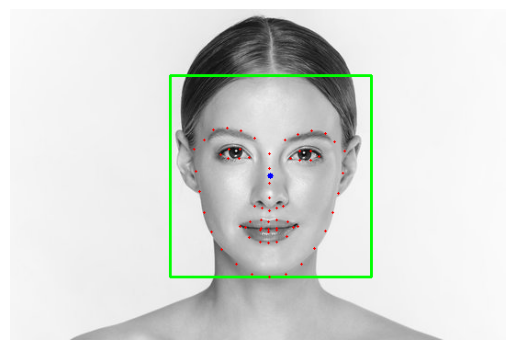

In [177]:
# %% Test FaceDetector
# Test FaceDetector with a sample image
img_path = "test_images/face.jpg"

# Instantiate the FaceDetector
face_detector = FaceDetector()

# Detect faces and landmarks in the image
img_rgb, face_rectangles, face_centers, landmarks_all_faces = face_detector.detect(img_path)

# Display the detected faces and landmarks
face_detector.display(img_rgb)


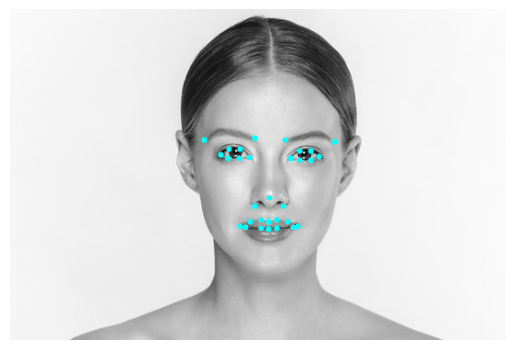

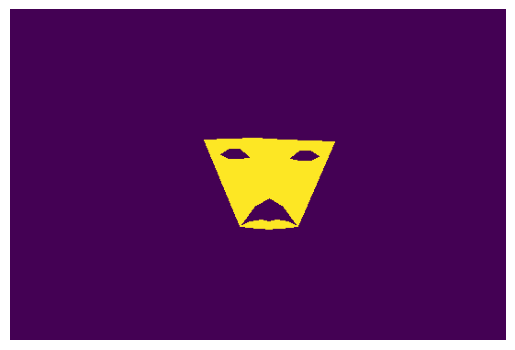

In [178]:

# %% Test MaskHandler
# Test MaskHandler with the detected landmarks
mask_handler = MaskHandler()

# Mask the points in the image using the landmarks from the FaceDetector
masked_img, selected_pts = mask_handler.mask_points(img_path, landmarks_all_faces)

# Display the result after masking the points
mask_handler.display(masked_img)

# Build the mask and display it
mask, masked_img = mask_handler.build_mask(img_path, selected_pts)
mask_handler.display(mask)

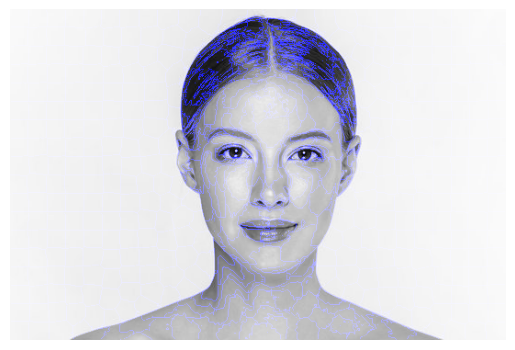

Superpixel Features: [{'label': np.int32(0), 'mean_intensity': 249.01923076923077, 'std_intensity': 0.3094899411429054, 'entropy': 0.1995776590439317}, {'label': np.int32(1), 'mean_intensity': 247.890243902439, 'std_intensity': 0.5366130813241377, 'entropy': 0.5129995764513827}, {'label': np.int32(2), 'mean_intensity': 247.05037783375315, 'std_intensity': 0.4626951037182901, 'entropy': 0.4406528881730701}, {'label': np.int32(3), 'mean_intensity': 246.06451612903226, 'std_intensity': 0.5464130284232552, 'entropy': 0.43857408383307867}, {'label': np.int32(4), 'mean_intensity': 244.9079283887468, 'std_intensity': 0.5174337176497401, 'entropy': 0.4150191380431606}, {'label': np.int32(5), 'mean_intensity': 242.9307875894988, 'std_intensity': 0.5633873856325623, 'entropy': 0.47357595828951515}, {'label': np.int32(6), 'mean_intensity': 241.46555819477436, 'std_intensity': 0.4988123515439429, 'entropy': 0.20843095381550236}, {'label': np.int32(7), 'mean_intensity': 240.8354114713217, 'std_inte

In [179]:

# %% Test SuperpixelFeatureExtractor
# Test SuperpixelFeatureExtractor with the test image
superpixel_extractor = SuperpixelFeatureExtractor(region_size=20, neighborhood_size=3)

# Get SLIC superpixels
slic, contoured_img, labels, num_superpixels = superpixel_extractor.get_slic_superpixels(img_path)

# Display the superpixels contours on the image
superpixel_extractor.display_superpixels(contoured_img)

# Extract basic features for each superpixel
features = superpixel_extractor.basic_superpixel_features(img_path, slic)

# Show extracted features for each superpixel
print("Superpixel Features:", features)
